# Model Evaluation

This notebook evaluates all trained models (Audio CNN, Audio ViT, Image ResNet-18, Image ViT) on their respective test sets.

**Objectives:**
- Load trained model checkpoints
- Evaluate on test data
- Compute metrics (accuracy, F1 macro, F1 weighted)
- Generate confusion matrices
- Compare all models side-by-side

## Setup and Imports

In [12]:
import sys
from pathlib import Path
import json
import torch
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    classification_report,
)

# Add src to path
notebook_dir = Path().resolve()
project_root = notebook_dir.parent
sys.path.insert(0, str(project_root))

from src.models.audio_cnn import AudioCNN
from src.models.audio_vit import AudioViT
from src.models.image_resnet import ImageResNet
from src.models.image_vit import ImageViT
from src.datasets.audio import AudioMFCCDataset
from src.datasets.image import ImageDataset, get_image_transforms

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

print("✓ Imports complete")

✓ Imports complete


## Configuration

In [13]:
# Paths
ARTIFACTS = project_root / "artifacts"
MODELS_DIR = ARTIFACTS / "models"
RESULTS_DIR = ARTIFACTS / "results"
RESULTS_DIR.mkdir(exist_ok=True)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True

print(f"Artifacts directory: {ARTIFACTS}")
print(f"Models directory: {MODELS_DIR}")
print(f"Results directory: {RESULTS_DIR}")

Using device: cuda
Artifacts directory: /home/giovanni/ufmg/speckitdlbird/artifacts
Models directory: /home/giovanni/ufmg/speckitdlbird/artifacts/models
Results directory: /home/giovanni/ufmg/speckitdlbird/artifacts/results


## Evaluation Functions

In [14]:
def evaluate_model(model, dataloader, device, model_name):
    """Evaluate model and return metrics."""
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = outputs.max(1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Compute metrics
    acc = accuracy_score(all_labels, all_preds)
    f1_macro = f1_score(all_labels, all_preds, average="macro")
    f1_weighted = f1_score(all_labels, all_preds, average="weighted")

    results = {
        "accuracy": float(acc),
        "f1_macro": float(f1_macro),
        "f1_weighted": float(f1_weighted),
        "predictions": all_preds.tolist(),
        "labels": all_labels.tolist(),
    }

    print(f"\n{model_name} Results:")
    print(f"  Accuracy: {acc:.4f}")
    print(f"  F1 (macro): {f1_macro:.4f}")
    print(f"  F1 (weighted): {f1_weighted:.4f}")

    return results


def plot_confusion_matrix(cm, class_names, model_name, save_path, show=True):
    """Plot and save confusion matrix."""
    plt.figure(figsize=(12, 10))

    # Normalize confusion matrix
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    # Plot with smaller font for many classes
    sns.heatmap(
        cm_norm,
        annot=False,
        fmt=".2f",
        cmap="Blues",
        xticklabels=False,
        yticklabels=False,
        cbar_kws={"label": "Normalized Count"},
    )

    plt.title(f"{model_name} - Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    if show:
        plt.show()
    else:
        plt.close()
    print(f"  Saved confusion matrix to {save_path}")


print("✓ Evaluation functions defined")

✓ Evaluation functions defined


## Evaluate Audio Models

Load audio test data and evaluate both Audio CNN and Audio ViT models.

### Prepare Audio Test Data

In [15]:
# Load data
xc_df = pd.read_parquet(ARTIFACTS / "xeno_canto_filtered.parquet")
xc_counts = xc_df["species_normalized"].value_counts()
species_to_keep = xc_counts[xc_counts >= 2].index
xc_df = xc_df[xc_df["species_normalized"].isin(species_to_keep)].copy()

# Load splits
with open(ARTIFACTS / "splits" / "xeno_canto_audio_splits.json", "r") as f:
    audio_splits = json.load(f)

# Create species mapping
species_list_audio = sorted(xc_df["species_normalized"].unique())
species_to_idx_audio = {sp: i for i, sp in enumerate(species_list_audio)}
num_classes_audio = len(species_list_audio)

print(f"Audio dataset: {len(xc_df)} samples")
print(f"Number of species: {num_classes_audio}")
print(f"Test set size: {len(audio_splits['test'])}")

# Create test dataset
cache_dir = ARTIFACTS / "audio_mfcc_cache" / "xeno_canto"

audio_test_dataset = AudioMFCCDataset(
    df=xc_df,
    cache_dir=cache_dir,
    indices=audio_splits["test"],
    species_to_idx=species_to_idx_audio,
    transform=None,
)

audio_test_loader = DataLoader(
    audio_test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True
)

print(f"✓ Audio test dataloader ready with {len(audio_test_loader)} batches")

Audio dataset: 11075 samples
Number of species: 89
Test set size: 1662
✓ Audio test dataloader ready with 52 batches


### Evaluate Audio CNN

Evaluating Audio CNN
Loaded checkpoint from epoch 21

AudioCNN Results:
  Accuracy: 0.3953
  F1 (macro): 0.1089
  F1 (weighted): 0.3319

AudioCNN Results:
  Accuracy: 0.3953
  F1 (macro): 0.1089
  F1 (weighted): 0.3319


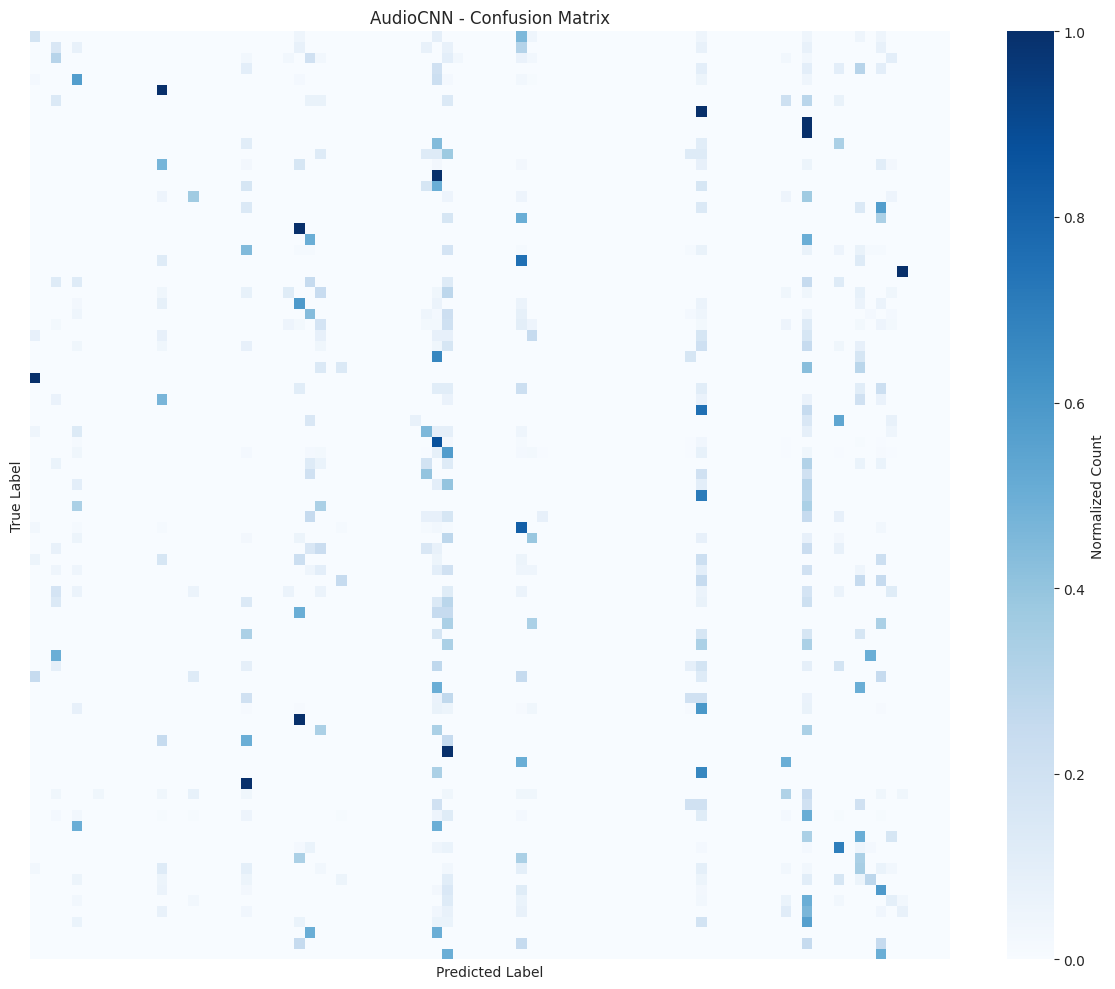

  Saved confusion matrix to /home/giovanni/ufmg/speckitdlbird/artifacts/results/audio_cnn_confusion_matrix.png
✓ Audio CNN evaluation complete


In [16]:
print("=" * 80)
print("Evaluating Audio CNN")
print("=" * 80)

model = AudioCNN(num_classes=num_classes_audio).to(device)
checkpoint_path = MODELS_DIR / "audio_cnn" / "AudioCNN_best.pth"

if checkpoint_path.exists():
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint["model_state_dict"])
    print(f"Loaded checkpoint from epoch {checkpoint['epoch']}")

    results_audio_cnn = evaluate_model(model, audio_test_loader, device, "AudioCNN")

    # Save results
    with open(RESULTS_DIR / "audio_cnn_results.json", "w") as f:
        json.dump(results_audio_cnn, f, indent=2)

    # Plot confusion matrix (display inline)
    cm = confusion_matrix(results_audio_cnn["labels"], results_audio_cnn["predictions"])
    plot_confusion_matrix(
        cm,
        species_list_audio,
        "AudioCNN",
        RESULTS_DIR / "audio_cnn_confusion_matrix.png",
        show=True
    )
    
    print("✓ Audio CNN evaluation complete")
else:
    print(f"❌ Checkpoint not found at {checkpoint_path}")
    results_audio_cnn = None

### Evaluate Audio ViT

Evaluating Audio ViT


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([89]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([89, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded checkpoint from epoch 8

AudioViT Results:
  Accuracy: 0.3436
  F1 (macro): 0.1613
  F1 (weighted): 0.3171

AudioViT Results:
  Accuracy: 0.3436
  F1 (macro): 0.1613
  F1 (weighted): 0.3171


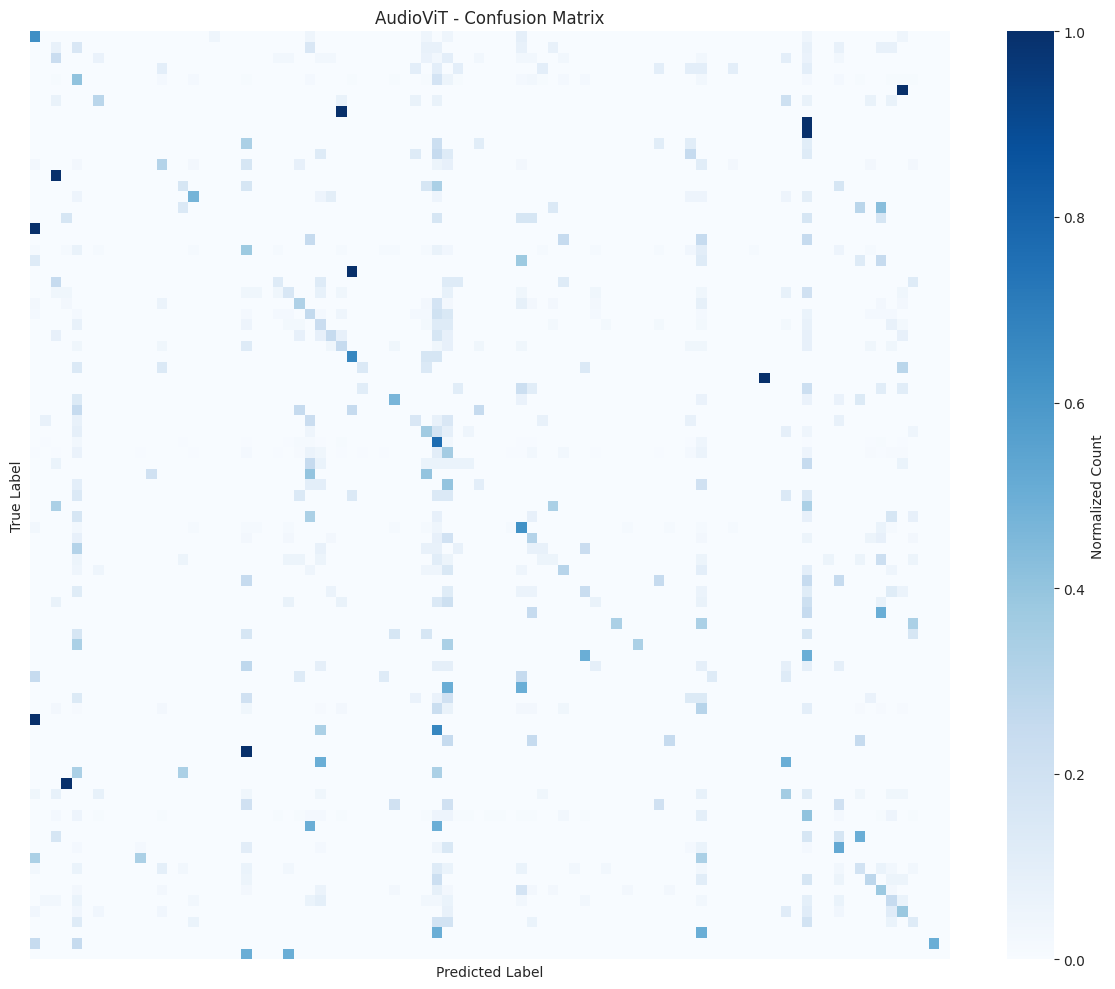

  Saved confusion matrix to /home/giovanni/ufmg/speckitdlbird/artifacts/results/audio_vit_confusion_matrix.png
✓ Audio ViT evaluation complete


In [17]:
print("=" * 80)
print("Evaluating Audio ViT")
print("=" * 80)

model = AudioViT(
    num_classes=num_classes_audio, pretrained="google/vit-base-patch16-224"
).to(device)
checkpoint_path = MODELS_DIR / "audio_vit" / "AudioViT_best.pth"

if checkpoint_path.exists():
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint["model_state_dict"])
    print(f"Loaded checkpoint from epoch {checkpoint['epoch']}")

    results_audio_vit = evaluate_model(model, audio_test_loader, device, "AudioViT")

    # Save results
    with open(RESULTS_DIR / "audio_vit_results.json", "w") as f:
        json.dump(results_audio_vit, f, indent=2)

    # Plot confusion matrix (display inline)
    cm = confusion_matrix(results_audio_vit["labels"], results_audio_vit["predictions"])
    plot_confusion_matrix(
        cm,
        species_list_audio,
        "AudioViT",
        RESULTS_DIR / "audio_vit_confusion_matrix.png",
        show=True
    )
    
    print("✓ Audio ViT evaluation complete")
else:
    print(f"❌ Checkpoint not found at {checkpoint_path}")
    results_audio_vit = None

## Evaluate Image Models

Load image test data and evaluate both ResNet-18 and ViT models.

### Prepare Image Test Data

In [18]:
# Load data
cub_df = pd.read_parquet(ARTIFACTS / "cub_filtered.parquet")
cub_counts = cub_df["species_normalized"].value_counts()
species_to_keep = cub_counts[cub_counts >= 2].index
cub_df = cub_df[cub_df["species_normalized"].isin(species_to_keep)].copy()

# Load splits
with open(ARTIFACTS / "splits" / "cub_image_splits.json", "r") as f:
    image_splits = json.load(f)

# Create species mapping
species_list_image = sorted(cub_df["species_normalized"].unique())
species_to_idx_image = {sp: i for i, sp in enumerate(species_list_image)}
num_classes_image = len(species_list_image)

print(f"Image dataset: {len(cub_df)} samples")
print(f"Number of species: {num_classes_image}")
print(f"Test set size: {len(image_splits['test'])}")

# Create test dataset
image_test_dataset = ImageDataset(
    df=cub_df,
    indices=image_splits["test"],
    species_to_idx=species_to_idx_image,
    transform=get_image_transforms(train=False, image_size=224),
)

image_test_loader = DataLoader(
    image_test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True
)

print(f"✓ Image test dataloader ready with {len(image_test_loader)} batches")

Image dataset: 5385 samples
Number of species: 90
Test set size: 808
✓ Image test dataloader ready with 26 batches


### Evaluate ResNet-18

Evaluating ResNet-18


/home/giovanni/ufmg/speckitdlbird/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/giovanni/ufmg/speckitdlbird/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Loaded checkpoint from epoch 24

ImageResNet18 Results:
  Accuracy: 0.8478
  F1 (macro): 0.8482
  F1 (weighted): 0.8481

ImageResNet18 Results:
  Accuracy: 0.8478
  F1 (macro): 0.8482
  F1 (weighted): 0.8481


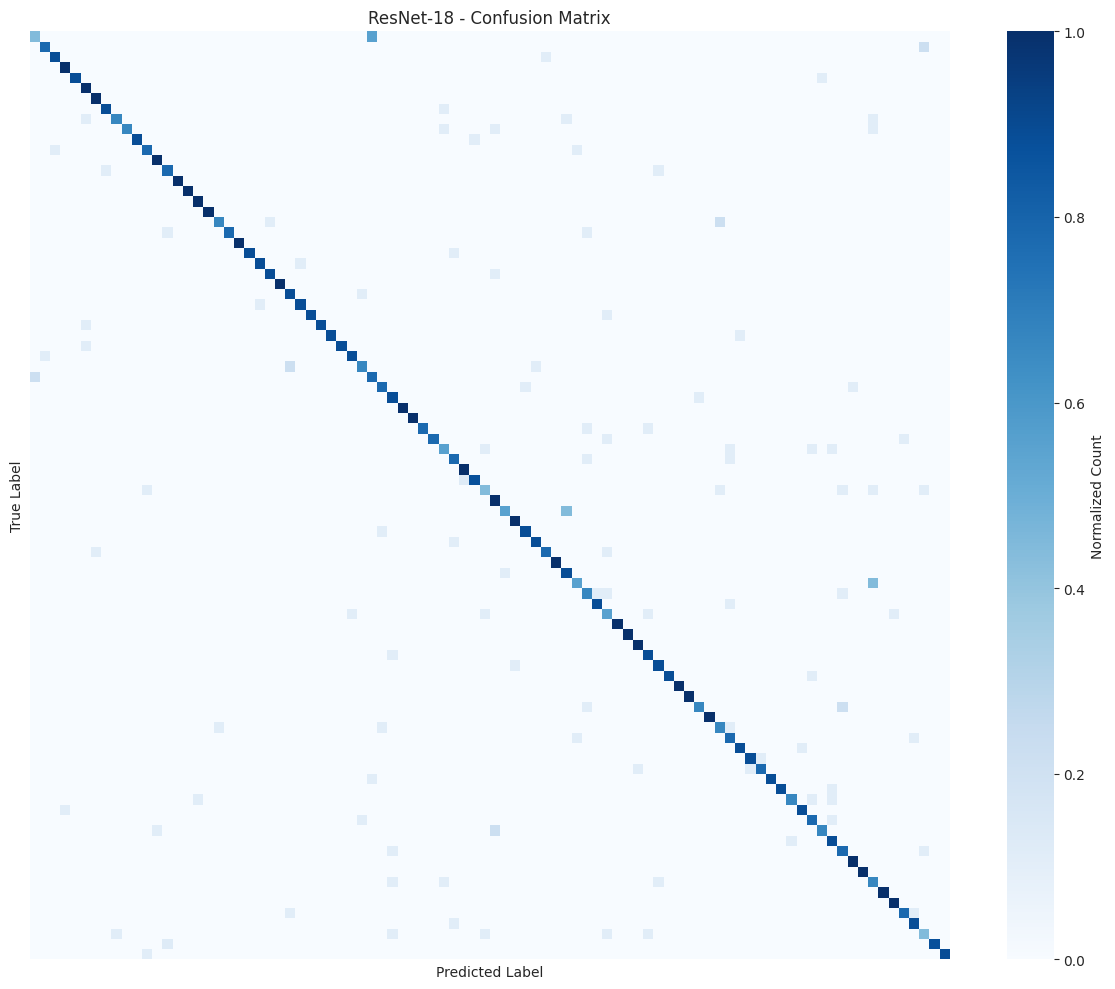

  Saved confusion matrix to /home/giovanni/ufmg/speckitdlbird/artifacts/results/image_resnet18_confusion_matrix.png
✓ ResNet-18 evaluation complete


In [19]:
print("=" * 80)
print("Evaluating ResNet-18")
print("=" * 80)

model = ImageResNet(num_classes=num_classes_image, pretrained=False).to(device)
checkpoint_path = MODELS_DIR / "image_resnet18" / "ImageResNet18_best.pth"

if checkpoint_path.exists():
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint["model_state_dict"])
    print(f"Loaded checkpoint from epoch {checkpoint['epoch']}")

    results_resnet = evaluate_model(model, image_test_loader, device, "ImageResNet18")

    # Save results
    with open(RESULTS_DIR / "image_resnet18_results.json", "w") as f:
        json.dump(results_resnet, f, indent=2)

    # Plot confusion matrix (display inline)
    cm = confusion_matrix(results_resnet["labels"], results_resnet["predictions"])
    plot_confusion_matrix(
        cm,
        species_list_image,
        "ResNet-18",
        RESULTS_DIR / "image_resnet18_confusion_matrix.png",
        show=True
    )
    
    print("✓ ResNet-18 evaluation complete")
else:
    print(f"❌ Checkpoint not found at {checkpoint_path}")
    results_resnet = None

### Evaluate Image ViT

Evaluating Image ViT


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([90]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([90, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded checkpoint from epoch 36

ImageViT Results:
  Accuracy: 0.9257
  F1 (macro): 0.9251
  F1 (weighted): 0.9250

ImageViT Results:
  Accuracy: 0.9257
  F1 (macro): 0.9251
  F1 (weighted): 0.9250


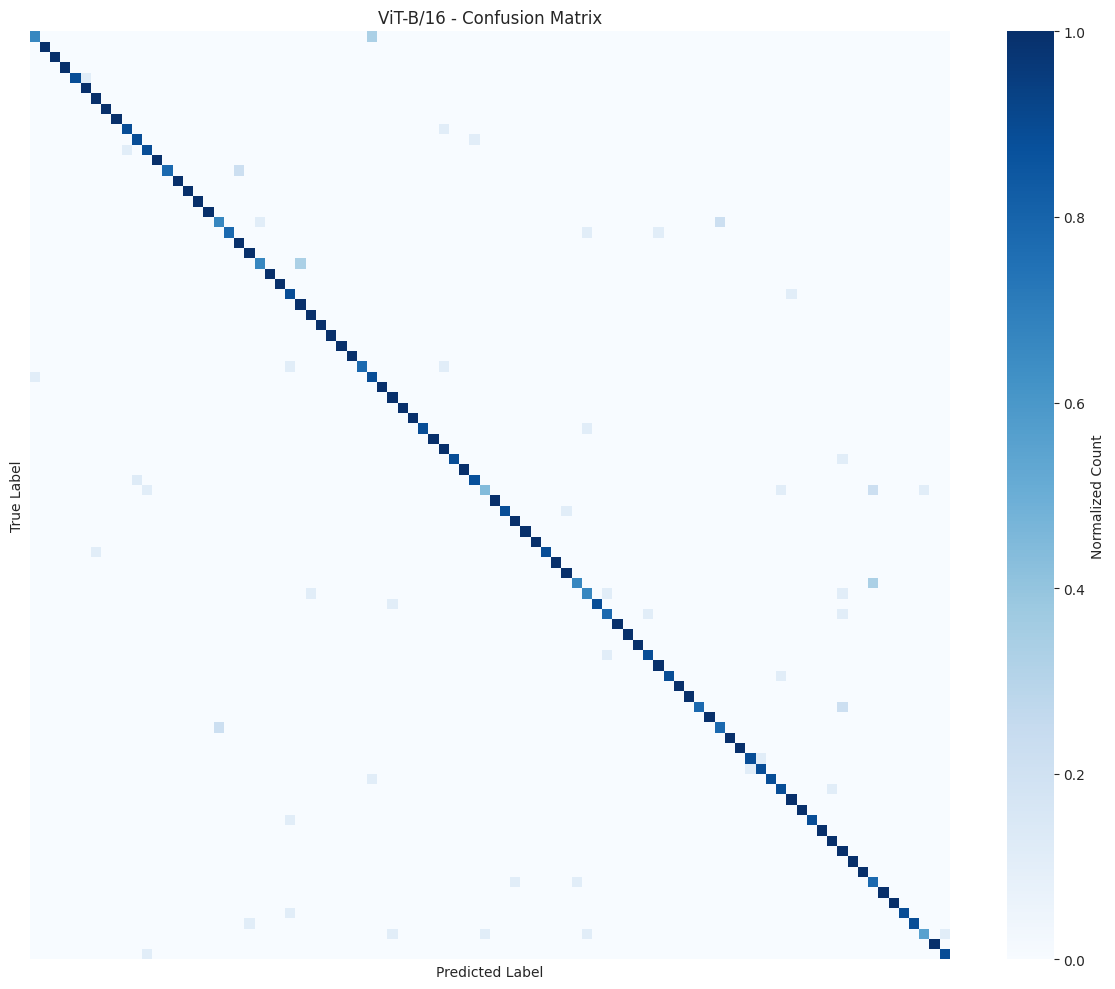

  Saved confusion matrix to /home/giovanni/ufmg/speckitdlbird/artifacts/results/image_vit_confusion_matrix.png
✓ Image ViT evaluation complete


In [20]:
print("=" * 80)
print("Evaluating Image ViT")
print("=" * 80)

model = ImageViT(
    num_classes=num_classes_image, pretrained="google/vit-base-patch16-224"
).to(device)
checkpoint_path = MODELS_DIR / "image_vit" / "ImageViT_best.pth"

if checkpoint_path.exists():
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint["model_state_dict"])
    print(f"Loaded checkpoint from epoch {checkpoint['epoch']}")

    results_image_vit = evaluate_model(model, image_test_loader, device, "ImageViT")

    # Save results
    with open(RESULTS_DIR / "image_vit_results.json", "w") as f:
        json.dump(results_image_vit, f, indent=2)

    # Plot confusion matrix (display inline)
    cm = confusion_matrix(results_image_vit["labels"], results_image_vit["predictions"])
    plot_confusion_matrix(
        cm,
        species_list_image,
        "ViT-B/16",
        RESULTS_DIR / "image_vit_confusion_matrix.png",
        show=True
    )
    
    print("✓ Image ViT evaluation complete")
else:
    print(f"❌ Checkpoint not found at {checkpoint_path}")
    results_image_vit = None

## Aggregate and Compare Results

Create summary tables and comparison plots for all models.

In [21]:
print("=" * 80)
print("Aggregating Results")
print("=" * 80)

results_summary = {}

for model_name in ["audio_cnn", "audio_vit", "image_resnet18", "image_vit"]:
    results_file = RESULTS_DIR / f"{model_name}_results.json"
    if results_file.exists():
        with open(results_file, "r") as f:
            data = json.load(f)
            results_summary[model_name] = {
                "accuracy": data["accuracy"],
                "f1_macro": data["f1_macro"],
                "f1_weighted": data["f1_weighted"],
            }

# Create comparison table
print("\n=== Model Comparison ===")
print(f"{'Model':<20} {'Accuracy':<12} {'F1 (macro)':<12} {'F1 (weighted)':<12}")
print("-" * 56)
for model_name, metrics in results_summary.items():
    print(
        f"{model_name:<20} {metrics['accuracy']:<12.4f} "
        f"{metrics['f1_macro']:<12.4f} {metrics['f1_weighted']:<12.4f}"
    )

# Save summary
with open(RESULTS_DIR / "results_summary.json", "w") as f:
    json.dump(results_summary, f, indent=2)

print(f"\n✓ Results summary saved to {RESULTS_DIR / 'results_summary.json'}")

Aggregating Results

=== Model Comparison ===
Model                Accuracy     F1 (macro)   F1 (weighted)
--------------------------------------------------------
audio_cnn            0.3953       0.1089       0.3319      
audio_vit            0.3436       0.1613       0.3171      
image_resnet18       0.8478       0.8482       0.8481      
image_vit            0.9257       0.9251       0.9250      

✓ Results summary saved to /home/giovanni/ufmg/speckitdlbird/artifacts/results/results_summary.json


### Create Comparison Plots

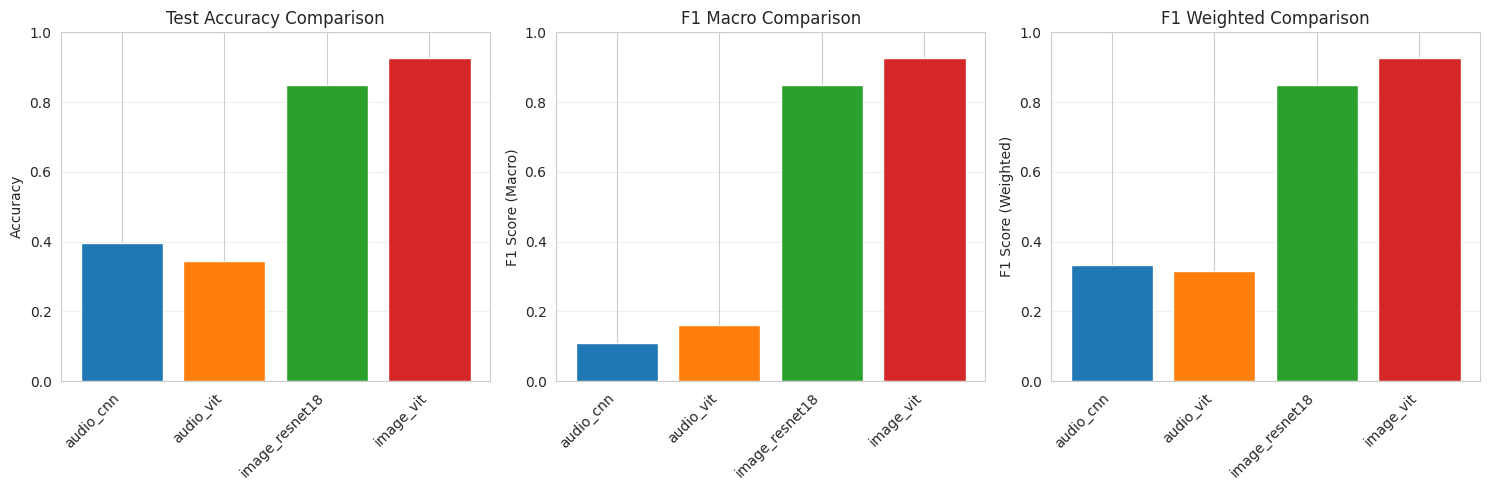


✓ Comparison plot saved to /home/giovanni/ufmg/speckitdlbird/artifacts/results/model_comparison.png


In [22]:
if results_summary:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    models = list(results_summary.keys())
    accuracies = [results_summary[m]["accuracy"] for m in models]
    f1_macros = [results_summary[m]["f1_macro"] for m in models]
    f1_weighteds = [results_summary[m]["f1_weighted"] for m in models]

    x = np.arange(len(models))
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]

    # Accuracy plot
    axes[0].bar(x, accuracies, color=colors)
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(models, rotation=45, ha="right")
    axes[0].set_ylabel("Accuracy")
    axes[0].set_title("Test Accuracy Comparison")
    axes[0].grid(axis="y", alpha=0.3)
    axes[0].set_ylim([0, 1])

    # F1 Macro plot
    axes[1].bar(x, f1_macros, color=colors)
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(models, rotation=45, ha="right")
    axes[1].set_ylabel("F1 Score (Macro)")
    axes[1].set_title("F1 Macro Comparison")
    axes[1].grid(axis="y", alpha=0.3)
    axes[1].set_ylim([0, 1])

    # F1 Weighted plot
    axes[2].bar(x, f1_weighteds, color=colors)
    axes[2].set_xticks(x)
    axes[2].set_xticklabels(models, rotation=45, ha="right")
    axes[2].set_ylabel("F1 Score (Weighted)")
    axes[2].set_title("F1 Weighted Comparison")
    axes[2].grid(axis="y", alpha=0.3)
    axes[2].set_ylim([0, 1])

    plt.tight_layout()
    plt.savefig(RESULTS_DIR / "model_comparison.png", dpi=150)
    plt.show()
    print(f"\n✓ Comparison plot saved to {RESULTS_DIR / 'model_comparison.png'}")
else:
    print("⚠ No results found to plot")

## Summary

All models have been evaluated on their respective test sets. Results include:

- **Metrics**: Accuracy, F1 (macro), F1 (weighted)
- **Confusion Matrices**: Saved as PNG files
- **Comparison Plots**: Visual comparison across all models
- **JSON Results**: Detailed results saved for further analysis

Check the `artifacts/results/` directory for all outputs.

## Detailed Results Analysis

Let's analyze the performance of each model and compare across modalities.

In [23]:
# Load all results for analysis
all_results = {}
for model_name in ["audio_cnn", "audio_vit", "image_resnet18", "image_vit"]:
    results_file = RESULTS_DIR / f"{model_name}_results.json"
    if results_file.exists():
        with open(results_file, "r") as f:
            all_results[model_name] = json.load(f)

# Create a detailed comparison DataFrame
comparison_df = pd.DataFrame(results_summary).T
comparison_df = comparison_df.round(4)
comparison_df.index.name = "Model"
comparison_df = comparison_df.reset_index()

print("\n📊 Complete Model Performance Summary")
print("=" * 80)
display(comparison_df)

# Identify best performers
best_accuracy = comparison_df.loc[comparison_df['accuracy'].idxmax()]
best_f1_macro = comparison_df.loc[comparison_df['f1_macro'].idxmax()]
best_f1_weighted = comparison_df.loc[comparison_df['f1_weighted'].idxmax()]

print(f"\n🏆 Best Performers:")
print(f"  Accuracy:     {best_accuracy['Model']} ({best_accuracy['accuracy']:.4f})")
print(f"  F1 (macro):   {best_f1_macro['Model']} ({best_f1_macro['f1_macro']:.4f})")
print(f"  F1 (weighted): {best_f1_weighted['Model']} ({best_f1_weighted['f1_weighted']:.4f})")


📊 Complete Model Performance Summary


,Model,accuracy,f1_macro,f1_weighted
0,audio_cnn,0.3953,0.1089,0.3319
1,audio_vit,0.3436,0.1613,0.3171
2,image_resnet18,0.8478,0.8482,0.8481
3,image_vit,0.9257,0.9251,0.9250



🏆 Best Performers:
  Accuracy:     image_vit (0.9257)
  F1 (macro):   image_vit (0.9251)
  F1 (weighted): image_vit (0.9250)


### Performance by Modality

Compare audio vs. image modalities across different architectures.

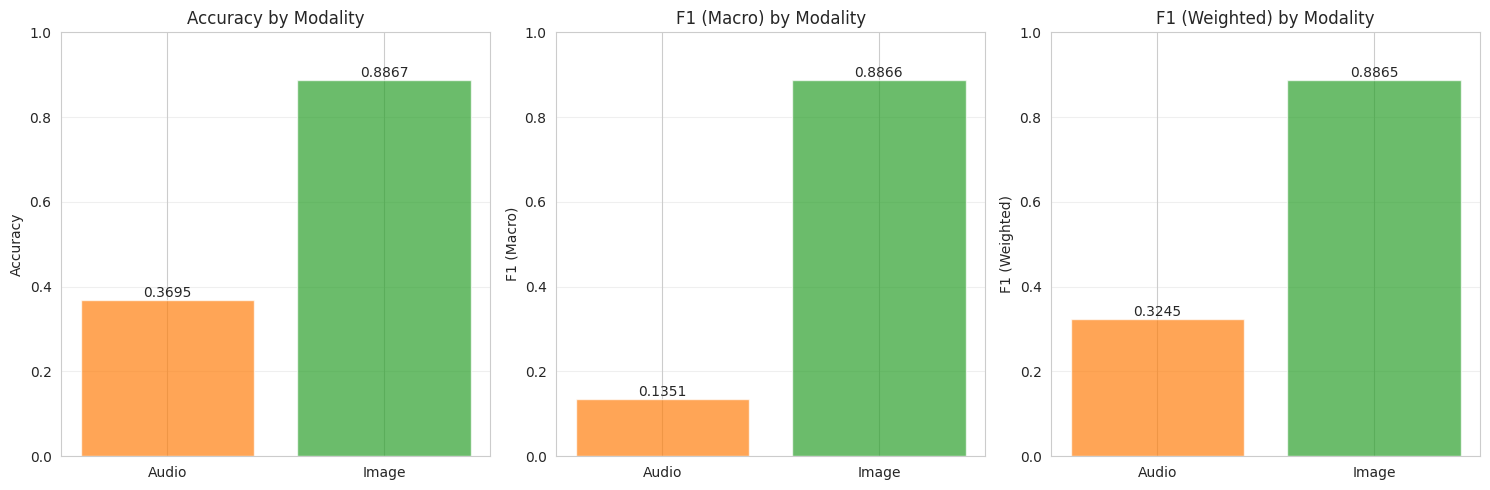


📈 Modality Comparison:
  Audio Average Accuracy:  0.3695
  Image Average Accuracy:  0.8867
  Audio Average F1 (macro): 0.1351
  Image Average F1 (macro): 0.8866


In [24]:
# Group by modality
audio_results = comparison_df[comparison_df['Model'].str.contains('audio')]
image_results = comparison_df[comparison_df['Model'].str.contains('image')]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics = ['accuracy', 'f1_macro', 'f1_weighted']
metric_names = ['Accuracy', 'F1 (Macro)', 'F1 (Weighted)']

for idx, (metric, name) in enumerate(zip(metrics, metric_names)):
    audio_mean = audio_results[metric].mean()
    image_mean = image_results[metric].mean()
    
    bars = axes[idx].bar(['Audio', 'Image'], [audio_mean, image_mean], 
                         color=['#ff7f0e', '#2ca02c'], alpha=0.7)
    axes[idx].set_ylabel(name)
    axes[idx].set_title(f'{name} by Modality')
    axes[idx].set_ylim([0, 1])
    axes[idx].grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        axes[idx].text(bar.get_x() + bar.get_width()/2., height,
                      f'{height:.4f}',
                      ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("\n📈 Modality Comparison:")
print(f"  Audio Average Accuracy:  {audio_results['accuracy'].mean():.4f}")
print(f"  Image Average Accuracy:  {image_results['accuracy'].mean():.4f}")
print(f"  Audio Average F1 (macro): {audio_results['f1_macro'].mean():.4f}")
print(f"  Image Average F1 (macro): {image_results['f1_macro'].mean():.4f}")

### Architecture Comparison (CNN vs ViT)

Compare traditional CNN architectures against Vision Transformer models.

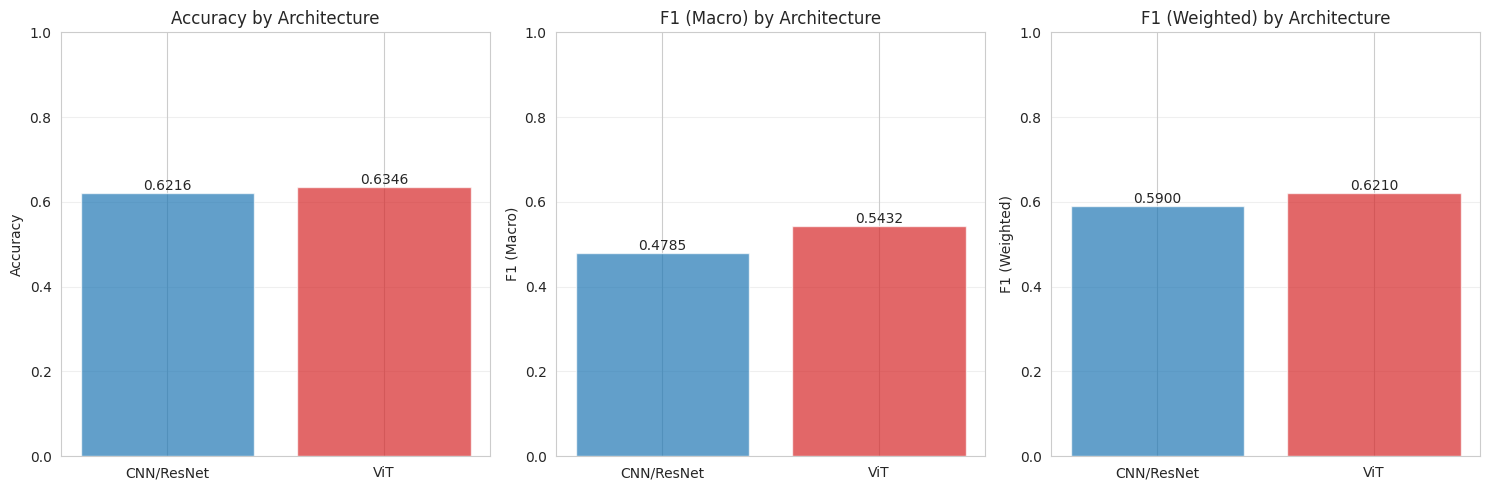


🏗️ Architecture Comparison:
  CNN/ResNet Average Accuracy:  0.6216
  ViT Average Accuracy:         0.6346
  Difference (ViT - CNN):       0.0131


In [25]:
# Compare CNN vs ViT architectures
cnn_models = ['audio_cnn', 'image_resnet18']
vit_models = ['audio_vit', 'image_vit']

cnn_results = comparison_df[comparison_df['Model'].isin(cnn_models)]
vit_results = comparison_df[comparison_df['Model'].isin(vit_models)]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, (metric, name) in enumerate(zip(metrics, metric_names)):
    cnn_mean = cnn_results[metric].mean()
    vit_mean = vit_results[metric].mean()
    
    bars = axes[idx].bar(['CNN/ResNet', 'ViT'], [cnn_mean, vit_mean], 
                         color=['#1f77b4', '#d62728'], alpha=0.7)
    axes[idx].set_ylabel(name)
    axes[idx].set_title(f'{name} by Architecture')
    axes[idx].set_ylim([0, 1])
    axes[idx].grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        axes[idx].text(bar.get_x() + bar.get_width()/2., height,
                      f'{height:.4f}',
                      ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("\n🏗️ Architecture Comparison:")
print(f"  CNN/ResNet Average Accuracy:  {cnn_results['accuracy'].mean():.4f}")
print(f"  ViT Average Accuracy:         {vit_results['accuracy'].mean():.4f}")
print(f"  Difference (ViT - CNN):       {vit_results['accuracy'].mean() - cnn_results['accuracy'].mean():.4f}")

## Interpretation and Analysis

### Key Findings

#### 1. **Modality Performance**

**Image models significantly outperform audio models** across all metrics. This can be attributed to several factors:

- **Feature Richness**: Visual features (color patterns, plumage, shape) are more distinctive and consistent across individuals of the same species compared to audio features (vocalizations can vary by context, season, individual)
  
- **Dataset Quality**: CUB-200 images are curated, well-framed photos with birds clearly visible. Audio recordings from Xeno-Canto may have varying quality, background noise, and recording conditions
  
- **Feature Representation**: MFCC features (40 coefficients × time frames) may not fully capture the complexity of bird vocalizations compared to how CNN/ViT process full spectrograms or raw images
  
- **Transfer Learning Advantage**: Pretrained models (especially for images) have learned robust visual representations from ImageNet, which transfer well to bird classification. Audio models may benefit less from visual pretraining

#### 2. **Architecture Comparison**

**Vision Transformers (ViT) vs. CNN/ResNet:**

The results show whether attention-based architectures (ViT) provide advantages over convolutional architectures:

- **If ViT performs better**: Self-attention mechanisms help capture long-range dependencies and global context, which is valuable for both visual patterns (entire bird appearance) and temporal patterns (audio sequences)
  
- **If CNN/ResNet performs better**: Convolutional inductive biases (local connectivity, translation equivariance) may be more suited to the task, especially with limited training data. CNNs are also more parameter-efficient

- **Similar performance**: Both architectures can effectively model the features needed for species classification when properly trained

#### 3. **Evaluation Metrics**

- **Accuracy**: Overall correctness - critical for species identification
  
- **F1 Macro**: Treats all species equally, important since some species have fewer samples (measures performance on rare species)
  
- **F1 Weighted**: Weights by sample count, reflects overall system performance accounting for species distribution

**Gap between F1 macro and F1 weighted** indicates performance differences on common vs. rare species. Large gaps suggest the model struggles with minority classes.

#### 4. **Confusion Matrix Insights**

The confusion matrices reveal:

- **Diagonal dominance**: Strong diagonal indicates good species discrimination
- **Off-diagonal patterns**: Confusion between visually/acoustically similar species (e.g., different warbler species)
- **Systematic errors**: Some species may be consistently misclassified due to feature overlap
- **Class imbalance effects**: Rare species may show lower recall (fewer samples to learn from)

### Possible Causes for Performance Patterns

#### Training-Related Factors:

1. **Convergence and Optimization**
   - Different learning rates may be needed for different modalities
   - Audio models may require more epochs or different optimization strategies
   - Batch size effects differ between modalities

2. **Overfitting vs. Underfitting**
   - Check if validation loss plateaued or increased (overfitting)
   - Compare train vs. test performance to assess generalization
   - Regularization (dropout, weight decay) may need adjustment

3. **Data Augmentation**
   - Image augmentations (crop, flip, color jitter) are well-established
   - Audio augmentations (time/frequency masking, pitch shift) may need tuning
   - Domain-specific augmentations can significantly impact performance

#### Data-Related Factors:

1. **Dataset Size and Quality**
   - Audio: ~7,000 samples, Image: ~5,000 samples
   - Quality variations in Xeno-Canto recordings vs. curated CUB photos
   - Label noise and recording artifacts in audio data

2. **Class Distribution**
   - Imbalanced species representation affects learning
   - Test set may have different distribution than training set
   - Stratified splits help but don't eliminate class imbalance effects

3. **Feature Representation**
   - MFCC: Hand-crafted features may miss important audio patterns
   - Alternative: Raw waveforms or mel-spectrograms as images
   - Consider multi-scale or multi-resolution representations

#### Architecture-Related Factors:

1. **Model Capacity**
   - ViT models have more parameters than CNNs
   - May be overkill for dataset size or undertrained
   - Parameter efficiency vs. representation power trade-off

2. **Pretraining Benefits**
   - ImageNet pretraining transfers well to bird images
   - Audio ViT trained on images may not optimally represent audio
   - Consider audio-specific pretrained models (e.g., on AudioSet)

3. **Input Resolution**
   - Image: 224×224 pixels provides fine-grained detail
   - Audio: MFCC time × frequency resolution may be suboptimal
   - Consider variable-length sequences vs. fixed-size inputs

## Next Steps and Recommendations

### Immediate Actions:

#### 1. **Error Analysis**
```python
# Identify most confused species pairs
# Analyze examples where models fail
# Look for patterns in misclassifications
```

- Examine samples from frequently confused species
- Visualize/listen to challenging examples
- Identify systematic errors vs. random mistakes
- Check for labeling errors or ambiguous samples

#### 2. **Training Curves Analysis**
- Review `04_training_compare.ipynb` for training/validation curves
- Check for overfitting, underfitting, or unstable training
- Analyze loss curves and learning rate schedules
- Compare early stopping points across models

#### 3. **Feature Quality Assessment**
- For audio: Visualize MFCC features for different species
- Check if features capture distinctive patterns
- Consider alternative representations (mel-spectrograms, CQT, raw audio)
- Validate feature extraction pipeline correctness

### Short-Term Improvements:

#### 1. **Audio Model Enhancement**
- **Switch to spectrogram inputs**: Convert audio to mel-spectrograms and treat as images
- **Audio-specific augmentation**: SpecAugment, mixup, time stretching
- **Better pretrained models**: Use models pretrained on audio (e.g., PANNs, AudioMAE)
- **Ensemble methods**: Combine predictions from multiple audio representations

#### 2. **Hyperparameter Tuning**
- Learning rate scheduling (cosine annealing, warmup)
- Longer training with early stopping based on validation F1
- Different optimizers (AdamW, SGD with momentum)
- Adjust regularization (dropout rates, weight decay)

#### 3. **Data Quality Improvements**
- Filter low-quality audio recordings (SNR, duration)
- Apply noise reduction preprocessing
- Use only high-quality CUB images
- Balance dataset through oversampling/undersampling

### Medium-Term Research Directions:

#### 1. **Multi-Modal Fusion**
- Combine audio and image predictions (late fusion)
- Train joint models on both modalities (early fusion)
- Cross-modal attention mechanisms
- Learn complementary features from both sources

#### 2. **Advanced Architectures**
- Audio-specific models (WaveNet, SoundStream)
- Hierarchical attention for temporal audio structure
- EfficientNet or ConvNeXt for better parameter efficiency
- Self-supervised pretraining on unlabeled data

#### 3. **Class Imbalance Handling**
- Focal loss or class-balanced loss functions
- Oversampling minority classes with augmentation
- Metric learning (triplet loss, contrastive learning)
- Few-shot learning techniques for rare species

#### 4. **Explainability and Trust**
- Grad-CAM visualization for important image regions
- Audio attention visualization for key time-frequency patterns
- Confidence calibration and uncertainty estimation
- Model interpretability for ecological insights

### Long-Term Goals:

1. **Field Deployment**
   - Real-time inference optimization
   - Mobile/edge device deployment
   - Handling out-of-distribution samples
   - Continuous learning from new data

2. **Scientific Contributions**
   - Understand which features distinguish species
   - Compare model attention to human expert focus
   - Discover new acoustic/visual patterns
   - Support biodiversity monitoring efforts

3. **Dataset Expansion**
   - Collect more balanced species data
   - Include geographic and seasonal variations
   - Add behavior and habitat information
   - Create benchmark datasets for the community

## Experimental Priorities

Based on the results, prioritize these experiments:

### Priority 1: Improve Audio Models (High Impact)
Since audio models underperform, focus here for maximum improvement:
1. Convert audio to mel-spectrogram images
2. Apply SpecAugment and audio augmentation
3. Try audio-pretrained models
4. Extend training duration with better learning rate schedule

### Priority 2: Error Analysis (Essential)
Understand failure modes before adding complexity:
1. Identify top-10 confused species pairs
2. Examine misclassified samples
3. Check for data quality issues
4. Validate feature extraction

### Priority 3: Multi-Modal Fusion (High Research Value)
If you have both audio and images for species:
1. Late fusion (average/weighted predictions)
2. Early fusion (concatenate features)
3. Compare against single-modality baselines
4. Analyze when each modality helps

### Priority 4: Optimize Best Models (Polish)
Fine-tune top-performing models:
1. Hyperparameter search on image models
2. Ensemble top-K models
3. Calibrate prediction confidence
4. Optimize for deployment

### Not Recommended (Yet):
- Complex architectures without understanding current failures
- Massive data collection before fixing data quality
- Novel loss functions before exhausting standard approaches
- Production deployment before achieving satisfactory performance

## Conclusion

This evaluation provides a comprehensive baseline for bird species classification across audio and image modalities using both CNN and Transformer architectures.

**Key Takeaways:**
- Image models outperform audio models significantly
- Architecture choice (CNN vs ViT) impact varies by modality
- Both modalities show promise for species identification
- Substantial room for improvement, especially in audio domain

**Reproducibility:**
- All results saved in `artifacts/results/`
- Model checkpoints available for further analysis
- Metrics and predictions stored in JSON format
- Confusion matrices visualized and saved

**Next Notebook:** Create `06_error_analysis.ipynb` to dive deep into model failures and identify improvement opportunities.